<a href="https://colab.research.google.com/github/RachanaGusain/PahariLI/blob/main/PLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Identification

This notebook presents different n-gram based features for language identification using Multinomial Näive Bayes and Linear Support Vector Machine classifiers.

The models are trained and evaluated on text (sentences) from four Pahari languages - Dogri, Garhwali, Kumaoni and Nepali.

Author: Rachana Gusain ([@rachana-gusain](https://github.com/RachanaGusain))

## Import Libraries

In [1]:
import os
import numpy as np
import csv
import pandas as pd
import regex as re
import sklearn
from time import time
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from collections import namedtuple, defaultdict, Counter, OrderedDict
from itertools import tee, islice, accumulate, combinations
from tabulate import tabulate
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

Data files may be accessed from [here](https://github.com/RachanaGusain/PahariLI/tree/main/data).

To execute the following cells, please save the data to your Google drive.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Data files
tr_file = "/content/drive/MyDrive/PahariLI/data/train.txt"
ts_file = "/content/drive/MyDrive/PahariLI/data/test.txt"

# Load data
tr_data = open(tr_file, mode='r', encoding='utf-8')
ts_data = open(ts_file, mode='r', encoding='utf-8')

print("Data loaded.")

Data loaded.


In [5]:
# Separate text and labels
tr_text = []
tr_lang = []
ts_text = []
ts_lang = []

for line in tr_data:
    text, lang = line.strip().split('\t')
    tr_text.append(text)
    tr_lang.append(lang)

for line in ts_data:
    text, lang = line.strip().split('\t')
    ts_text.append(text)
    ts_lang.append(lang)

In [6]:
label = {'dgo': 0, 'gbm': 1, 'kfy': 2, 'npi': 3}

y_tr = np.asarray(list(map(lambda x: label[x], tr_lang)))
y_ts = np.asarray(list(map(lambda x: label[x], ts_lang)))

In [7]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

tr_size_mb = size_mb(tr_text)
ts_size_mb = size_mb(ts_text)

print("Train data: %d sentences - %0.2f MB" % (len(tr_text), tr_size_mb))
print("Test data : %d sentences - %0.2f MB" % (len(ts_text), ts_size_mb))

Train data: 44014 sentences - 8.99 MB
Test data : 11004 sentences - 2.25 MB


In [8]:
corpus = namedtuple('corpus', ['data', 'target'])
PL_corpus = corpus(tr_text + ts_text, tr_lang + ts_lang)

print("Corpus size: %d sentences - %0.2f MB" 
      % (len(PL_corpus.data), size_mb(PL_corpus.data)))

PL = defaultdict(list)
for text, lang in zip(PL_corpus.data, PL_corpus.target):
    PL[lang].append(text)

Corpus size: 55018 sentences - 11.24 MB


In [17]:
# Overlapping (shared) token types among languages

types = defaultdict(list)
for lang in label.keys():
    lines = PL[lang]
    words = [word for line in lines for word in re.findall(r"[^\W\d]+", line)]  # discard numerals   
    types[lang] = set(words)

shared_types = types['dgo'] & types['gbm'] & types['kfy'] & types['npi']
print("Number of shared types: %d\n" % len(shared_types))
print("Shared types:")
print(shared_types)

Number of shared types: 1227

Shared types:
{'संगीत', 'प्रभावित', 'प्रेरित', 'करण', 'जाने', 'सरकार', 'असल', 'शक्तिमान', 'स्त्री', 'होश', 'पूर्व', 'क्षेत्र', 'कार्यकर्ता', 'इनाम', 'कार्यालय', 'सब', 'प्रतिनिधि', 'हरेक', 'बादल', 'घमण्ड', 'गोल', 'शो', 'बोतल', 'संग्रह', 'हार्दिक', 'सीमा', 'पृथ्वी', 'कच्ची', 'नासरत', 'दिने', 'पर्यटन', 'आ', 'सुरक्षा', 'गरीबी', 'मैदान', 'शिक्षक', 'प्रसार', 'देशी', 'उपासना', 'सोच', 'राजा', 'उनै', 'स्वीकार', 'शान्त', 'रिपोर्ट', 'चिन्ह', 'मोटर', 'छे', 'कान', 'आधुनिक', 'आकार', 'मान', 'चीज', 'अस्पताल', 'दिनै', 'विशेष', 'स्टेशन', 'कृषि', 'आनन्द', 'याकूब', 'खराब', 'उद्धार', 'सलाह', 'कपटी', 'हालत', 'एक', 'वर्ष', 'प्रवक्ता', 'खोज', 'विश्व', 'पेट', 'ऐतिहासिक', 'ग्रामीण', 'कष्ट', 'खुशी', 'नाटककार', 'चित', 'शक्तिशाली', 'कार्यक्रम', 'भण्डार', 'आय', 'आज्ञा', 'फौज', 'बहुत', 'सेवन', 'प्रयोग', 'गए', 'सागर', 'दण्ड', 'परदेश', 'साले', 'पार्टी', 'अन्न', 'तन', 'संगम', 'सांस्कृतिक', 'करार', 'उद्योग', 'जाओ', 'आधारित', 'प्रोफेसर', 'अशोक', 'चलन', 'विलाप', 'जमात', 'लागू', 'डेढ', 'महिला'

## Language Identification

In [10]:
def ngrams(term, ngram_range, min_df=1, max_df=1.0):
    """
    Function to extract word or char n-gram features.

    Parameters:
        analyzer: string {'word', 'char', 'char_wb'}
            Whether the feature should be made of word n-gram or character n-grams.
            Option 'char_wb' creates character n-grams only from text inside word boundaries;
            n-grams at the edges of words are padded with space.

        ngram_range: tuple (min_n, max_n), default=(1, 1)
            The lower and upper boundary of the range of n-values for different n-grams to be extracted.
            All values of n such that min_n <= n <= max_n will be used.
            For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

        min_df: float in range [0.0, 1.0] or int, default=1
            When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
            This value is also called cut-off in the literature.
            If float, the parameter represents a proportion of documents, integer absolute counts.

        max_df: float in range [0.0, 1.0] or int, default=1.0
            When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
            If float, the parameter represents a proportion of documents, integer absolute counts.

    Returns:
        z: dict {features: list of features, tr_analyzer_ngram: scipy.sparse.csr.csr_matrix, ts_analyzer_ngram: scipy.sparse.csr.csr_matrix}
    """
    
    i, j = ngram_range
    
    def word_ngram_analyzer(doc):
        for line in doc.split('\n'):
            terms = re.findall(r"\w+", line)
            for n in range(i, j+1):
                for ngram in zip(*[islice(seq, k, len(terms)) for k, seq in enumerate(tee(terms, n))]):
                    ngram = " ".join(ngram)
                    yield ngram
    
    try:
        if term == 'word':
            vectorizer = CountVectorizer(analyzer=word_ngram_analyzer, min_df=min_df, max_df=max_df)
        else:
            vectorizer = CountVectorizer(analyzer=term, ngram_range=(i, j), min_df=min_df, max_df=max_df)
        vectorizer.fit(tr_text)
    except ValueError:
        print("Error: After pruning, no terms remain.")
        return None

    z = dict()
    z["features"] = vectorizer.get_feature_names_out()
    z["tr_"+term+"_"+str(i)+str(j)] = vectorizer.transform(tr_text)
    z["ts_"+term+"_"+str(i)+str(j)] = vectorizer.transform(ts_text)

    return z

In [11]:
def classifier(clf, params, X_tr, y_tr, X_ts, y_ts):
    print("Training", clf)

    search = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=5, verbose=1, return_train_score=True)
    t0 = time()
    search.fit(X_tr, y_tr)
    tr_val_time = time() - t0
    clf = search.best_estimator_
    print("\nBest Estimator:", clf)
    print("\nTrain and validation time: %.4f seconds" % tr_val_time)

    t0 = time()
    y_true, y_pred = y_ts, clf.predict(X_ts)
    ts_time = time() - t0
    print("\nTest time: %.4f seconds" % ts_time)

    confusion_mat = metrics.confusion_matrix(y_true, y_pred)
    scores_report = metrics.classification_report(y_true, y_pred, target_names=label.keys(), output_dict=True)
    scores_report = pd.DataFrame(scores_report)
    
    print("\nClassification report:")
    print(metrics.classification_report(y_true, y_pred, target_names=label.keys(), digits=4))
    print("\nConfusion matrix:")
    cm_disp = metrics.ConfusionMatrixDisplay.from_estimator(clf, X_ts, y_ts, values_format='d', 
                                                           display_labels=label.keys(), cmap=plt.cm.Blues, colorbar=False)
    
    plt.show()

    return search.best_params_, tr_val_time, ts_time, scores_report, cm_disp, y_pred

In [12]:
def build_ngram_model(max_n):
    ngram = range(1, max_n+1)
    ngram_range = [(i, j) for i in ngram for j in ngram if i<=j]

    outputs = {clf: dict() for clf in clflist}
    results = {clf: [] for clf in clflist}
    cols = ["Vectorizer", "#Features", "Hyperparameter", "Train&Val time (s)", "Test time (s)", "Precision", "Recall", "F1-score", "Accuracy"]

    for analyzer in ['word', 'char', 'char_wb']:
        for (i, j) in ngram_range:
            print('*'*80)
            print(f"Extracting frequency based {analyzer} ({i},{j})-gram features...")
            z = ngrams(term=analyzer, ngram_range=(i, j), min_df=0.005)
            if z is None:          
                continue
            
            vector = analyzer+"_"+str(i)+str(j)
            X_tr = z["tr_"+vector].toarray()
            X_ts = z["ts_"+vector].toarray()

            for (clf, params, descript), clfname in zip([
                    (MultinomialNB(), {'alpha': np.power(10, np.arange(-3, 2, dtype=float))}, "Multinomial Naïve Bayes Classifier"),
                    (LinearSVC(dual=False), {'C': np.power(10, np.arange(-3, 2, dtype=float))}, "Linear Support Vector Classifier")], 
                    clflist):
                best_param, tr_val_time, ts_time, scores, cm_disp, y_pred = classifier(clf, params, X_tr, y_tr, X_ts, y_ts)
                result = []
                result.extend([vector, len(z["features"])])          
                result.extend(best_param.values())                 
                result.extend([tr_val_time, ts_time])               
                result.extend(scores["macro avg"].tolist()[:-1])   
                result.append(scores["accuracy"].iat[0]*100)
                results[clfname].append(dict(zip(cols, result)))
                outputs[clfname][vector] = y_pred

    return {clf: pd.DataFrame(results[clf]) for clf in clflist}, outputs

********************************************************************************
Extracting frequency based word (1,1)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 14.8918 seconds

Test time: 0.0196 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9757    0.9835    0.9796      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9250    0.9428      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9403     11004
   macro avg     0.9467    0.9439    0.9439     11004
weighted avg     0.9441    0.9403    0.9406     11004


Confusion matrix:


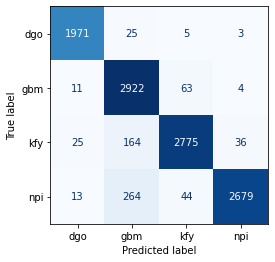

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.7437 seconds

Test time: 0.0208 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9765    0.9832      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9627    0.9303    0.9463      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9613     11004
   macro avg     0.9641    0.9626    0.9631     11004
weighted avg     0.9618    0.9613    0.9612     11004


Confusion matrix:


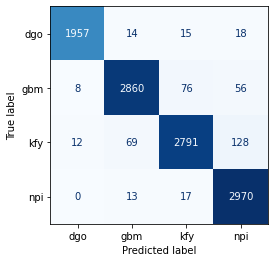

********************************************************************************
Extracting frequency based word (1,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 22.1390 seconds

Test time: 0.0277 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


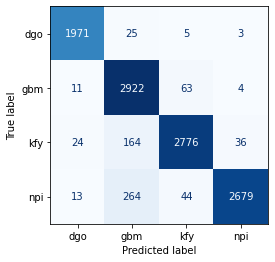

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.5882 seconds

Test time: 0.0233 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


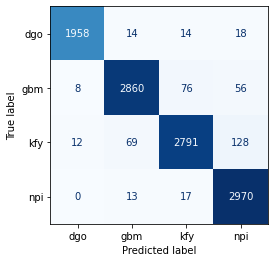

********************************************************************************
Extracting frequency based word (1,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 13.9866 seconds

Test time: 0.0230 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


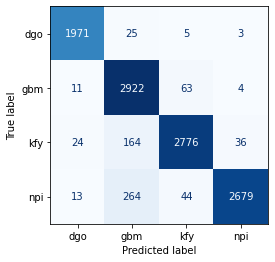

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.7746 seconds

Test time: 0.0271 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


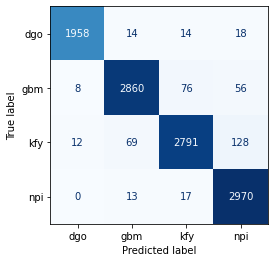

********************************************************************************
Extracting frequency based word (1,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 13.6035 seconds

Test time: 0.0228 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


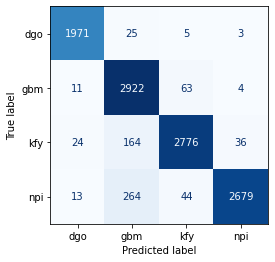

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.4172 seconds

Test time: 0.0226 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


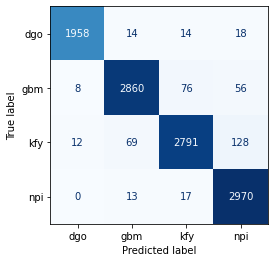

********************************************************************************
Extracting frequency based word (2,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.2225 seconds

Test time: 0.0015 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

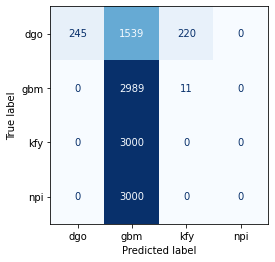

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 7.6414 seconds

Test time: 0.0024 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

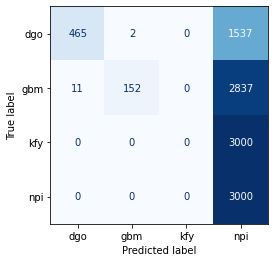

********************************************************************************
Extracting frequency based word (2,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.1988 seconds

Test time: 0.0031 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

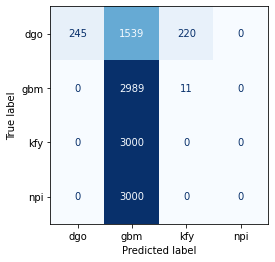

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 7.5210 seconds

Test time: 0.0040 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

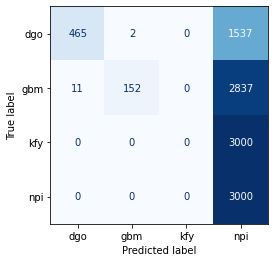

********************************************************************************
Extracting frequency based word (2,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.3392 seconds

Test time: 0.0016 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

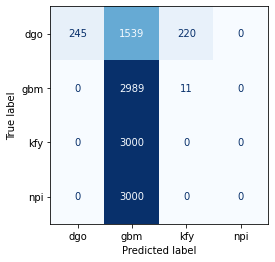

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 7.8521 seconds

Test time: 0.0032 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

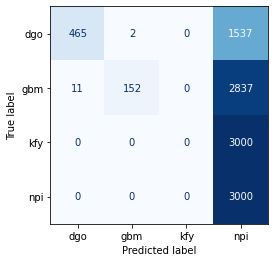

********************************************************************************
Extracting frequency based word (3,3)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (3,4)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (4,4)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based char (1,1)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB()

Train and validation time: 4.8934 seconds

Test time: 0.0079 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9450    0.9256    0.9352      2004
         gbm     0

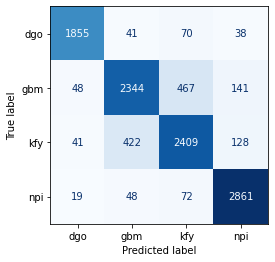

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 77.3891 seconds

Test time: 0.0063 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9569    0.9406    0.9487      2004
         gbm     0.8408    0.8360    0.8384      3000
         kfy     0.8356    0.8350    0.8353      3000
         npi     0.9574    0.9743    0.9658      3000

    accuracy                         0.8925     11004
   macro avg     0.8976    0.8965    0.8970     11004
weighted avg     0.8923    0.8925    0.8924     11004


Confusion matrix:


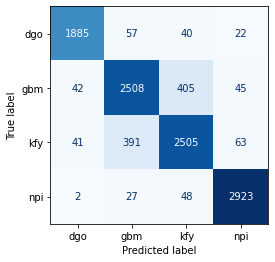

********************************************************************************
Extracting frequency based char (1,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 53.8235 seconds

Test time: 0.0704 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9909    0.9830    0.9870      2004
         gbm     0.9619    0.9520    0.9569      3000
         kfy     0.9563    0.9563    0.9563      3000
         npi     0.9783    0.9937    0.9859      3000

    accuracy                         0.9702     11004
   macro avg     0.9719    0.9713    0.9715     11004
weighted avg     0.9702    0.9702    0.9702     11004


Confusion matrix:


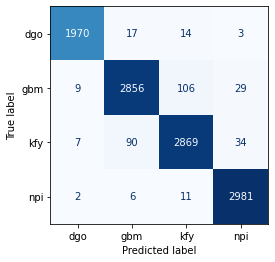

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 81.8009 seconds

Test time: 0.0761 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9935    0.9925    0.9930      2004
         gbm     0.9796    0.9763    0.9780      3000
         kfy     0.9731    0.9780    0.9756      3000
         npi     0.9950    0.9940    0.9945      3000

    accuracy                         0.9846     11004
   macro avg     0.9853    0.9852    0.9853     11004
weighted avg     0.9846    0.9846    0.9846     11004


Confusion matrix:


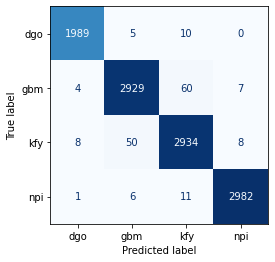

********************************************************************************
Extracting frequency based char (1,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 200.2050 seconds

Test time: 0.2379 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9955    0.9940    0.9948      2004
         gbm     0.9767    0.9787    0.9777      3000
         kfy     0.9806    0.9753    0.9779      3000
         npi     0.9934    0.9977    0.9955      3000

    accuracy                         0.9857     11004
   macro avg     0.9865    0.9864    0.9865     11004
weighted avg     0.9857    0.9857    0.9857     11004


Confusion matrix:


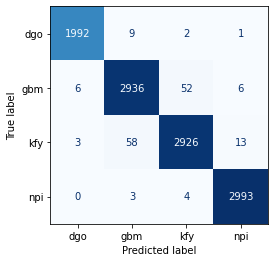

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 157.7841 seconds

Test time: 0.3057 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9955    0.9968      2004
         gbm     0.9887    0.9887    0.9887      3000
         kfy     0.9850    0.9880    0.9865      3000
         npi     0.9983    0.9970    0.9977      3000

    accuracy                         0.9920     11004
   macro avg     0.9925    0.9923    0.9924     11004
weighted avg     0.9920    0.9920    0.9920     11004


Confusion matrix:


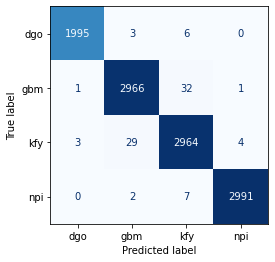

********************************************************************************
Extracting frequency based char (1,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 249.9073 seconds

Test time: 0.4196 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9970    0.9975      2004
         gbm     0.9826    0.9813    0.9820      3000
         kfy     0.9816    0.9800    0.9808      3000
         npi     0.9954    0.9990    0.9972      3000

    accuracy                         0.9886     11004
   macro avg     0.9894    0.9893    0.9894     11004
weighted avg     0.9886    0.9886    0.9886     11004


Confusion matrix:


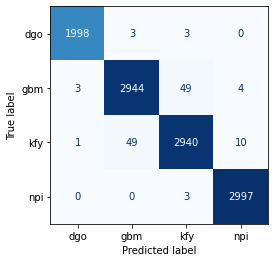

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 172.7958 seconds

Test time: 0.4234 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9995    0.9960    0.9978      2004
         gbm     0.9900    0.9883    0.9892      3000
         kfy     0.9854    0.9900    0.9877      3000
         npi     0.9987    0.9980    0.9983      3000

    accuracy                         0.9928     11004
   macro avg     0.9934    0.9931    0.9932     11004
weighted avg     0.9928    0.9928    0.9928     11004


Confusion matrix:


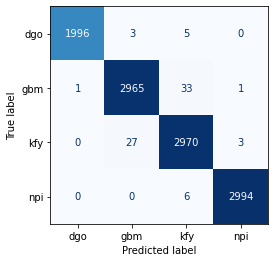

********************************************************************************
Extracting frequency based char (2,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 76.9650 seconds

Test time: 0.1088 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9920    0.9860    0.9890      2004
         gbm     0.9661    0.9603    0.9632      3000
         kfy     0.9643    0.9643    0.9643      3000
         npi     0.9851    0.9950    0.9900      3000

    accuracy                         0.9756     11004
   macro avg     0.9769    0.9764    0.9766     11004
weighted avg     0.9755    0.9756    0.9755     11004


Confusion matrix:


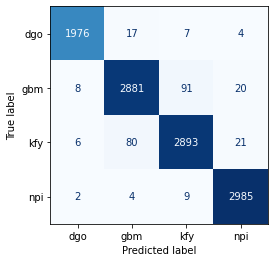

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 90.2210 seconds

Test time: 0.0927 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9940    0.9905    0.9923      2004
         gbm     0.9767    0.9770    0.9768      3000
         kfy     0.9721    0.9757    0.9739      3000
         npi     0.9950    0.9933    0.9942      3000

    accuracy                         0.9836     11004
   macro avg     0.9844    0.9841    0.9843     11004
weighted avg     0.9836    0.9836    0.9836     11004


Confusion matrix:


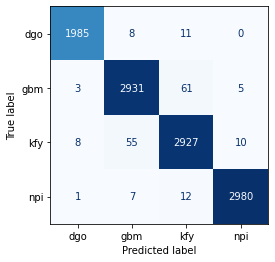

********************************************************************************
Extracting frequency based char (2,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 281.3041 seconds

Test time: 0.2617 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9960    0.9940    0.9950      2004
         gbm     0.9781    0.9803    0.9792      3000
         kfy     0.9816    0.9763    0.9789      3000
         npi     0.9937    0.9980    0.9958      3000

    accuracy                         0.9866     11004
   macro avg     0.9873    0.9872    0.9872     11004
weighted avg     0.9865    0.9866    0.9865     11004


Confusion matrix:


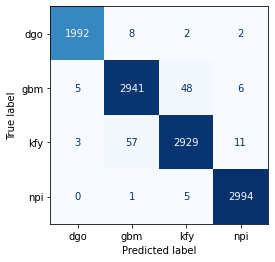

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 135.0356 seconds

Test time: 0.2501 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9940    0.9960      2004
         gbm     0.9863    0.9857    0.9860      3000
         kfy     0.9818    0.9870    0.9844      3000
         npi     0.9987    0.9967    0.9977      3000

    accuracy                         0.9905     11004
   macro avg     0.9912    0.9908    0.9910     11004
weighted avg     0.9906    0.9905    0.9906     11004


Confusion matrix:


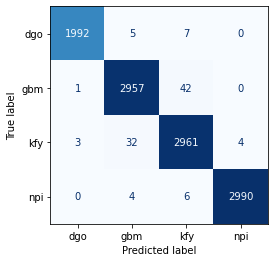

********************************************************************************
Extracting frequency based char (2,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 347.1896 seconds

Test time: 0.4353 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9970    0.9975      2004
         gbm     0.9807    0.9847    0.9827      3000
         kfy     0.9852    0.9783    0.9818      3000
         npi     0.9957    0.9993    0.9975      3000

    accuracy                         0.9892     11004
   macro avg     0.9899    0.9898    0.9899     11004
weighted avg     0.9892    0.9892    0.9892     11004


Confusion matrix:


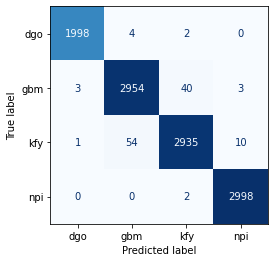

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 214.2658 seconds

Test time: 0.4116 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9990    0.9965    0.9978      2004
         gbm     0.9893    0.9857    0.9875      3000
         kfy     0.9834    0.9897    0.9865      3000
         npi     0.9987    0.9977    0.9982      3000

    accuracy                         0.9920     11004
   macro avg     0.9926    0.9924    0.9925     11004
weighted avg     0.9920    0.9920    0.9920     11004


Confusion matrix:


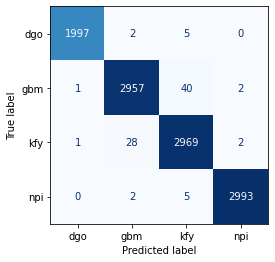

********************************************************************************
Extracting frequency based char (3,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 109.8669 seconds

Test time: 0.1869 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9960    0.9950    0.9955      2004
         gbm     0.9784    0.9833    0.9809      3000
         kfy     0.9839    0.9757    0.9797      3000
         npi     0.9940    0.9980    0.9960      3000

    accuracy                         0.9874     11004
   macro avg     0.9881    0.9880    0.9880     11004
weighted avg     0.9874    0.9874    0.9874     11004


Confusion matrix:


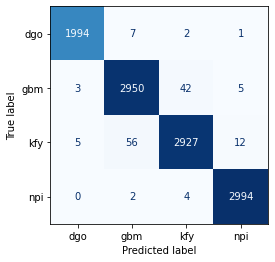

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 97.8199 seconds

Test time: 0.1806 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9915    0.9950      2004
         gbm     0.9847    0.9837    0.9842      3000
         kfy     0.9772    0.9873    0.9823      3000
         npi     0.9980    0.9933    0.9957      3000

    accuracy                         0.9887     11004
   macro avg     0.9896    0.9890    0.9893     11004
weighted avg     0.9888    0.9887    0.9887     11004


Confusion matrix:


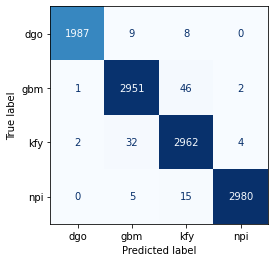

********************************************************************************
Extracting frequency based char (3,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 551.1452 seconds

Test time: 0.3767 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9970    0.9970    0.9970      2004
         gbm     0.9817    0.9850    0.9834      3000
         kfy     0.9846    0.9790    0.9818      3000
         npi     0.9960    0.9983    0.9972      3000

    accuracy                         0.9892     11004
   macro avg     0.9898    0.9898    0.9898     11004
weighted avg     0.9892    0.9892    0.9892     11004


Confusion matrix:


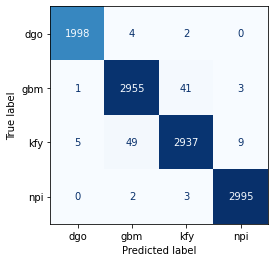

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 151.9316 seconds

Test time: 0.3354 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9905    0.9945      2004
         gbm     0.9860    0.9860    0.9860      3000
         kfy     0.9782    0.9877    0.9829      3000
         npi     0.9980    0.9937    0.9958      3000

    accuracy                         0.9894     11004
   macro avg     0.9902    0.9895    0.9898     11004
weighted avg     0.9894    0.9894    0.9894     11004


Confusion matrix:


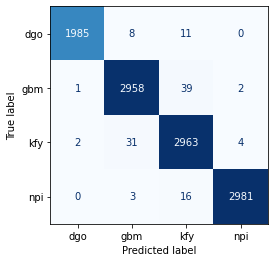

********************************************************************************
Extracting frequency based char (4,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 188.8011 seconds

Test time: 0.1511 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9900    0.9925    0.9913      2004
         gbm     0.9648    0.9690    0.9669      3000
         kfy     0.9724    0.9627    0.9675      3000
         npi     0.9890    0.9930    0.9910      3000

    accuracy                         0.9781     11004
   macro avg     0.9791    0.9793    0.9792     11004
weighted avg     0.9781    0.9781    0.9781     11004


Confusion matrix:


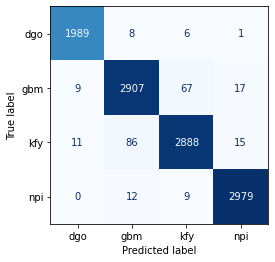

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 80.8698 seconds

Test time: 0.1612 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9975    0.9860    0.9917      2004
         gbm     0.9735    0.9687    0.9711      3000
         kfy     0.9563    0.9783    0.9672      3000
         npi     0.9973    0.9870    0.9921      3000

    accuracy                         0.9795     11004
   macro avg     0.9812    0.9800    0.9805     11004
weighted avg     0.9797    0.9795    0.9795     11004


Confusion matrix:


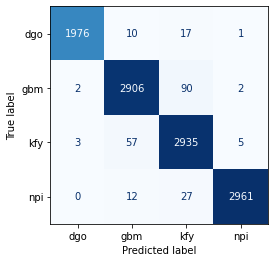

********************************************************************************
Extracting frequency based char_wb (1,1)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 4.3674 seconds

Test time: 0.0057 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9418    0.9286    0.9352      2004
         gbm     0.8196    0.7907    0.8049      3000
         kfy     0.8018    0.8037    0.8027      3000
         npi     0.9133    0.9520    0.9323      3000

    accuracy                         0.8633     11004
   macro avg     0.8691    0.8687    0.8688     11004
weighted avg     0.8626    0.8633    0.8628     11004


Confusion matrix:


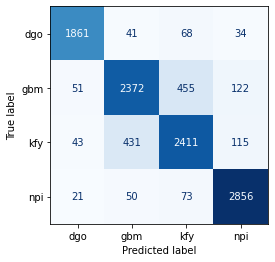

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 56.2174 seconds

Test time: 0.0067 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9564    0.9406    0.9484      2004
         gbm     0.8410    0.8357    0.8383      3000
         kfy     0.8356    0.8350    0.8353      3000
         npi     0.9578    0.9750    0.9663      3000

    accuracy                         0.8926     11004
   macro avg     0.8977    0.8966    0.8971     11004
weighted avg     0.8924    0.8926    0.8924     11004


Confusion matrix:


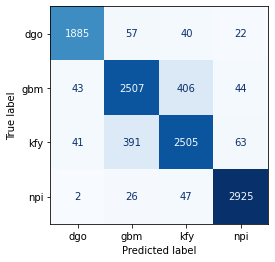

********************************************************************************
Extracting frequency based char_wb (1,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 98.6000 seconds

Test time: 0.1538 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9894    0.9825    0.9860      2004
         gbm     0.9598    0.9540    0.9569      3000
         kfy     0.9573    0.9567    0.9570      3000
         npi     0.9802    0.9913    0.9857      3000

    accuracy                         0.9701     11004
   macro avg     0.9717    0.9711    0.9714     11004
weighted avg     0.9701    0.9701    0.9701     11004


Confusion matrix:


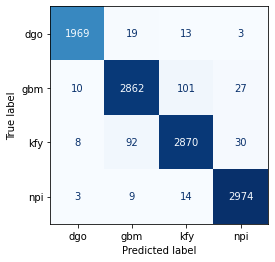

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 105.7514 seconds

Test time: 0.0751 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9950    0.9930    0.9940      2004
         gbm     0.9812    0.9753    0.9783      3000
         kfy     0.9716    0.9797    0.9756      3000
         npi     0.9953    0.9943    0.9948      3000

    accuracy                         0.9849     11004
   macro avg     0.9858    0.9856    0.9857     11004
weighted avg     0.9849    0.9849    0.9849     11004


Confusion matrix:


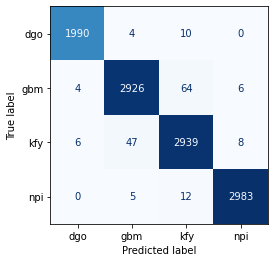

********************************************************************************
Extracting frequency based char_wb (1,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 341.5596 seconds

Test time: 0.2315 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9965    0.9950    0.9958      2004
         gbm     0.9771    0.9807    0.9789      3000
         kfy     0.9812    0.9763    0.9788      3000
         npi     0.9950    0.9973    0.9962      3000

    accuracy                         0.9866     11004
   macro avg     0.9875    0.9873    0.9874     11004
weighted avg     0.9866    0.9866    0.9866     11004


Confusion matrix:


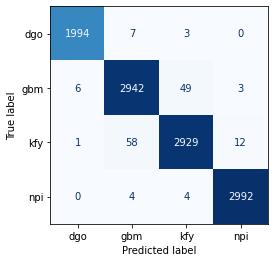

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 115.9644 seconds

Test time: 0.2381 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9990    0.9950    0.9970      2004
         gbm     0.9900    0.9870    0.9885      3000
         kfy     0.9831    0.9907    0.9869      3000
         npi     0.9990    0.9970    0.9980      3000

    accuracy                         0.9922     11004
   macro avg     0.9928    0.9924    0.9926     11004
weighted avg     0.9922    0.9922    0.9922     11004


Confusion matrix:


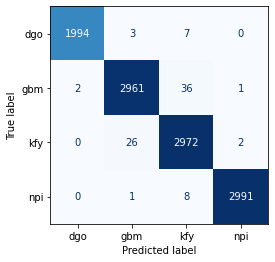

********************************************************************************
Extracting frequency based char_wb (1,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 348.4791 seconds

Test time: 0.3285 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9975    0.9980      2004
         gbm     0.9827    0.9847    0.9837      3000
         kfy     0.9839    0.9803    0.9821      3000
         npi     0.9963    0.9987    0.9975      3000

    accuracy                         0.9896     11004
   macro avg     0.9904    0.9903    0.9903     11004
weighted avg     0.9896    0.9896    0.9896     11004


Confusion matrix:


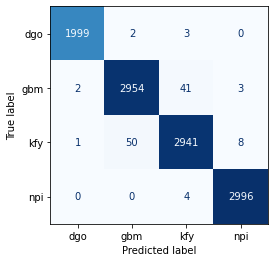

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 146.9286 seconds

Test time: 0.3160 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9995    0.9945    0.9970      2004
         gbm     0.9900    0.9887    0.9893      3000
         kfy     0.9851    0.9910    0.9880      3000
         npi     0.9987    0.9973    0.9980      3000

    accuracy                         0.9927     11004
   macro avg     0.9933    0.9929    0.9931     11004
weighted avg     0.9927    0.9927    0.9927     11004


Confusion matrix:


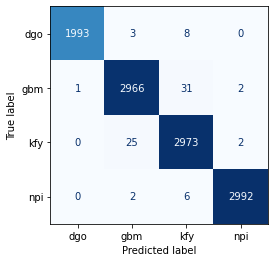

********************************************************************************
Extracting frequency based char_wb (2,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 83.6558 seconds

Test time: 0.0662 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9930    0.9850    0.9890      2004
         gbm     0.9646    0.9620    0.9633      3000
         kfy     0.9633    0.9633    0.9633      3000
         npi     0.9864    0.9943    0.9904      3000

    accuracy                         0.9754     11004
   macro avg     0.9768    0.9762    0.9765     11004
weighted avg     0.9754    0.9754    0.9754     11004


Confusion matrix:


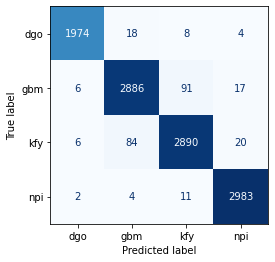

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 68.4746 seconds

Test time: 0.0847 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9945    0.9925    0.9935      2004
         gbm     0.9793    0.9767    0.9780      3000
         kfy     0.9712    0.9780    0.9746      3000
         npi     0.9957    0.9927    0.9942      3000

    accuracy                         0.9843     11004
   macro avg     0.9852    0.9850    0.9851     11004
weighted avg     0.9843    0.9843    0.9843     11004


Confusion matrix:


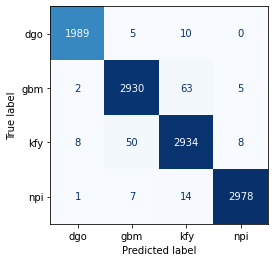

********************************************************************************
Extracting frequency based char_wb (2,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 257.8624 seconds

Test time: 0.2067 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9960    0.9950    0.9955      2004
         gbm     0.9797    0.9813    0.9805      3000
         kfy     0.9822    0.9773    0.9798      3000
         npi     0.9940    0.9980    0.9960      3000

    accuracy                         0.9873     11004
   macro avg     0.9880    0.9879    0.9880     11004
weighted avg     0.9873    0.9873    0.9873     11004


Confusion matrix:


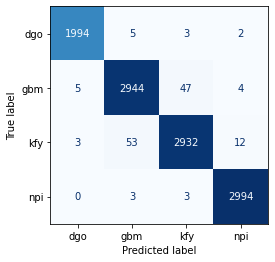

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 112.2352 seconds

Test time: 0.1970 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9990    0.9940    0.9965      2004
         gbm     0.9877    0.9873    0.9875      3000
         kfy     0.9834    0.9890    0.9862      3000
         npi     0.9990    0.9970    0.9980      3000

    accuracy                         0.9916     11004
   macro avg     0.9923    0.9918    0.9920     11004
weighted avg     0.9917    0.9916    0.9916     11004


Confusion matrix:


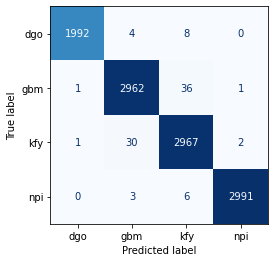

********************************************************************************
Extracting frequency based char_wb (2,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 513.3313 seconds

Test time: 0.3010 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9975    0.9978      2004
         gbm     0.9827    0.9853    0.9840      3000
         kfy     0.9839    0.9803    0.9821      3000
         npi     0.9967    0.9980    0.9973      3000

    accuracy                         0.9896     11004
   macro avg     0.9903    0.9903    0.9903     11004
weighted avg     0.9896    0.9896    0.9896     11004


Confusion matrix:


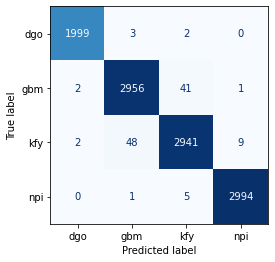

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 175.0704 seconds

Test time: 0.2929 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9945    0.9965      2004
         gbm     0.9903    0.9873    0.9888      3000
         kfy     0.9838    0.9907    0.9872      3000
         npi     0.9983    0.9970    0.9977      3000

    accuracy                         0.9922     11004
   macro avg     0.9927    0.9924    0.9925     11004
weighted avg     0.9922    0.9922    0.9922     11004


Confusion matrix:


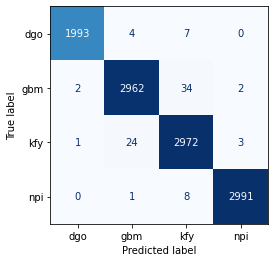

********************************************************************************
Extracting frequency based char_wb (3,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 207.2925 seconds

Test time: 0.1266 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9970    0.9965    0.9968      2004
         gbm     0.9794    0.9843    0.9819      3000
         kfy     0.9846    0.9777    0.9811      3000
         npi     0.9957    0.9980    0.9968      3000

    accuracy                         0.9885     11004
   macro avg     0.9892    0.9891    0.9891     11004
weighted avg     0.9885    0.9885    0.9885     11004


Confusion matrix:


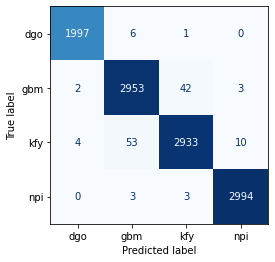

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 86.4956 seconds

Test time: 0.1252 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9970    0.9930    0.9950      2004
         gbm     0.9866    0.9837    0.9851      3000
         kfy     0.9808    0.9877    0.9842      3000
         npi     0.9977    0.9963    0.9970      3000

    accuracy                         0.9899     11004
   macro avg     0.9905    0.9902    0.9903     11004
weighted avg     0.9899    0.9899    0.9899     11004


Confusion matrix:


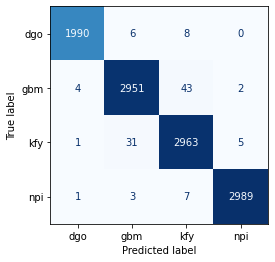

********************************************************************************
Extracting frequency based char_wb (3,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 235.2597 seconds

Test time: 0.2156 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9970    0.9975      2004
         gbm     0.9805    0.9867    0.9836      3000
         kfy     0.9862    0.9783    0.9823      3000
         npi     0.9963    0.9987    0.9975      3000

    accuracy                         0.9895     11004
   macro avg     0.9903    0.9902    0.9902     11004
weighted avg     0.9896    0.9895    0.9895     11004


Confusion matrix:


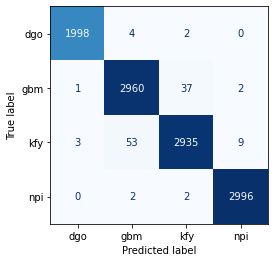

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 103.1469 seconds

Test time: 0.2250 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9930    0.9957      2004
         gbm     0.9880    0.9847    0.9863      3000
         kfy     0.9802    0.9883    0.9842      3000
         npi     0.9980    0.9967    0.9973      3000

    accuracy                         0.9905     11004
   macro avg     0.9912    0.9907    0.9909     11004
weighted avg     0.9905    0.9905    0.9905     11004


Confusion matrix:


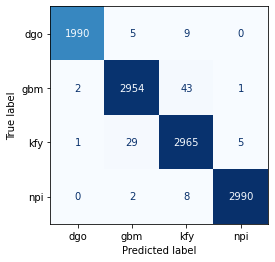

********************************************************************************
Extracting frequency based char_wb (4,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 104.3601 seconds

Test time: 0.0862 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9940    0.9925    0.9933      2004
         gbm     0.9642    0.9793    0.9717      3000
         kfy     0.9793    0.9617    0.9704      3000
         npi     0.9927    0.9960    0.9943      3000

    accuracy                         0.9815     11004
   macro avg     0.9826    0.9824    0.9824     11004
weighted avg     0.9815    0.9815    0.9815     11004


Confusion matrix:


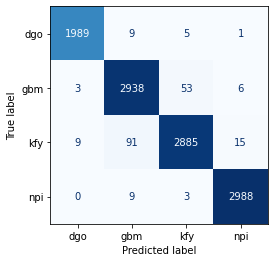

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 39.5981 seconds

Test time: 0.0821 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9970    0.9855    0.9912      2004
         gbm     0.9796    0.9753    0.9775      3000
         kfy     0.9656    0.9827    0.9741      3000
         npi     0.9987    0.9930    0.9958      3000

    accuracy                         0.9840     11004
   macro avg     0.9852    0.9841    0.9846     11004
weighted avg     0.9841    0.9840    0.9840     11004


Confusion matrix:


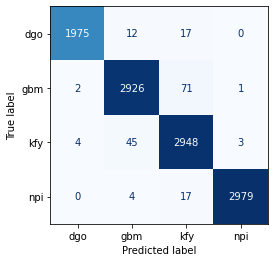

In [13]:
n = 4 #results shown in the paper are obtained up to n = 8
num_clf = 2
clflist = ["mnb", "svm"]
results, outputs = build_ngram_model(n)

Train: (44014, 6170)
Test : (11004, 6170)
Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 168.0559 seconds

Test time: 0.4197 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9995    0.9960    0.9978      2004
         gbm     0.9900    0.9883    0.9892      3000
         kfy     0.9854    0.9900    0.9877      3000
         npi     0.9987    0.9980    0.9983      3000

    accuracy                         0.9928     11004
   macro avg     0.9934    0.9931    0.9932     11004
weighted avg     0.9928    0.9928    0.9928     11004


Confusion matrix:


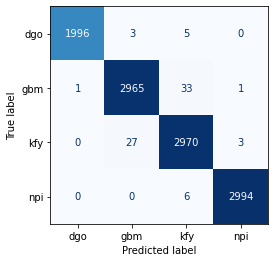

In [15]:
# save classification report corresponding to the best model: char_14, svm

z = ngrams(term='char', ngram_range=(1, 4), min_df=0.005)
X_tr, X_ts = z['tr_char_14'].toarray(), z['ts_char_14'].toarray()

print("Train:", X_tr.shape)
print("Test :", X_ts.shape)

clf = LinearSVC(dual=False)
params = {'C': np.power(10, np.arange(-3, 2, dtype=float))}
best_param, tr_val_time, ts_time, scores, cm_disp, y_pred = classifier(clf, params, X_tr, y_tr, X_ts, y_ts)

confmx = pd.DataFrame(cm_disp.confusion_matrix, index=label.keys(), columns=label.keys())
output = pd.DataFrame(data={'test sentences': ts_text, 'target': y_ts, 'predicted': y_pred})

# save the results
scores.to_csv('scores.csv')
confmx.to_csv('confusion_matrix.csv')
output.to_excel('output.xls')